In [1]:
import numpy as np
import matplotlib.pyplot as plt
import mkl

mkl.set_num_threads(2)
np.random.seed(1234)

%matplotlib inline
%config InlineBackend.figure_format = 'retina'
plt.rcParams["figure.figsize"] = [16, 9]

In [2]:
# arrange 2D matrices as tiles (takes 4D `examples` tensor with dims: rows x cols x tile_height x tile_width)
def tiles(examples):
    rows_count = examples.shape[0]
    cols_count = examples.shape[1]
    tile_height = examples.shape[2]
    tile_width = examples.shape[3]
    
    space_between_tiles = 2
    # img_matrix = np.empty(shape=( ??? ))
    # img_matrix.fill(np.nan)

    img_height = rows_count * (tile_height + space_between_tiles) - space_between_tiles
    img_width = cols_count * (tile_width + space_between_tiles) - space_between_tiles
    
    img_matrix = np.empty(shape=(img_height, img_width))
    img_matrix.fill(np.nan)

    for i in range(rows_count):
        for j in range(cols_count):
            row_start = i * (tile_height + space_between_tiles)
            row_end = row_start + tile_height
            col_start = j * (tile_width + space_between_tiles)
            col_end = col_start + tile_width
            img_matrix[row_start:row_end, col_start:col_end] = examples[i, j]

    return img_matrix

## MNIST Dataset

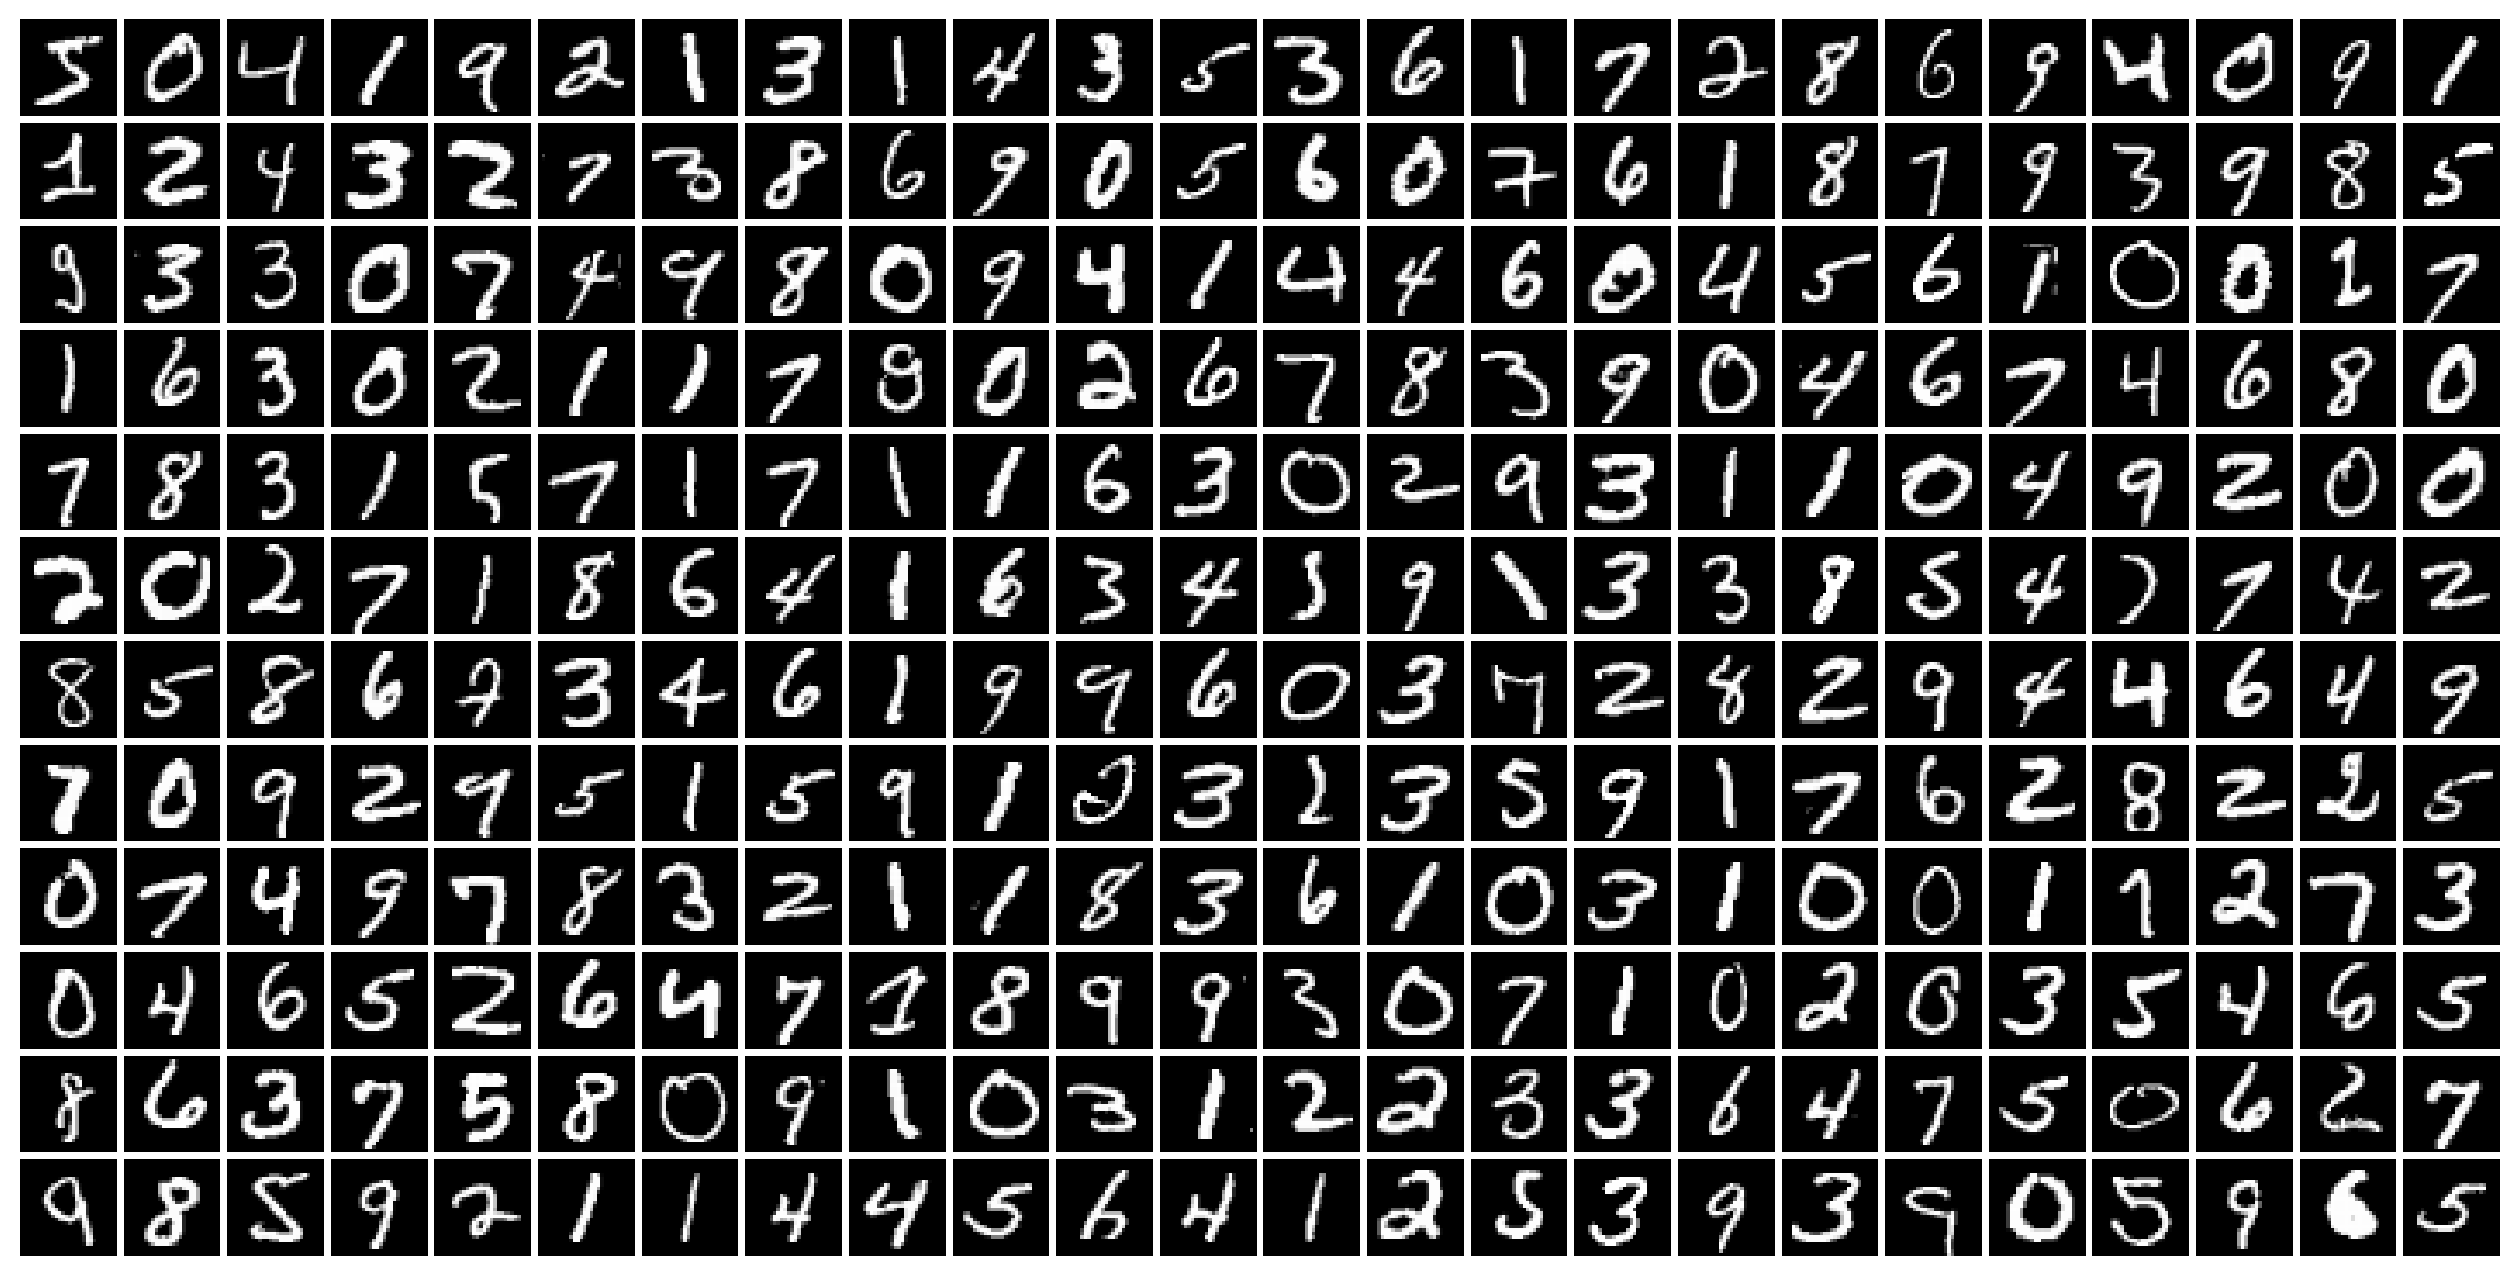

In [3]:
import mnist
digits = np.reshape(mnist.train_images()[:12*24], newshape=(12, 24, 28, 28))
img = tiles(digits)

plt.matshow(img, cmap='gray', interpolation='none')
plt.axis('off')
plt.show()

In [4]:
X = mnist.train_images().astype(np.float32) / 255.0
y = mnist.train_labels()
X.shape

(60000, 28, 28)

Reshape `X` so that the last two dimensions are collapsed into single dimension.

In [5]:
X = X.reshape(X.shape[0], -1)

In [6]:
X.shape

(60000, 784)

## Visualizing the distribution of MNIST digits

Add a scatter plot to `plot`, which:
* displys the first two dimensions of `X`,
* includes only these elements from `X` for which `y == i` (i.e. elements from the i-th class),
* includes label (i.e. `i`) in the legend.


In [7]:
def plot_2d_mnist_scatter(X, y):
    fig, plot = plt.subplots()
    fig.set_size_inches(16, 16)
    plt.prism()

    for i in range(10):
        digit_indeces = y == i
        dim1 = X[digit_indeces, 0]
        dim2 = X[digit_indeces, 1]
        plot.scatter(dim1, dim2)

    plot.set_xticks(())
    plot.set_yticks(())

    plt.tight_layout()
    plt.legend()
    plt.show()

### Principal Component Analysis (PCA)

In [8]:
SAMPLES_LIMIT = 2000
X_small = X[:SAMPLES_LIMIT]
y_small = y[:SAMPLES_LIMIT]

Use PCA function to embed `X_small` in two dimensions. Store the result in `X_pca_embedded`.

In [9]:
from sklearn.decomposition import PCA

pca = PCA(n_components=2)
pca.fit(X_small)
X_pca_embedded = pca.transform(X_small)

In [10]:
X_pca_embedded.shape

(2000, 2)

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


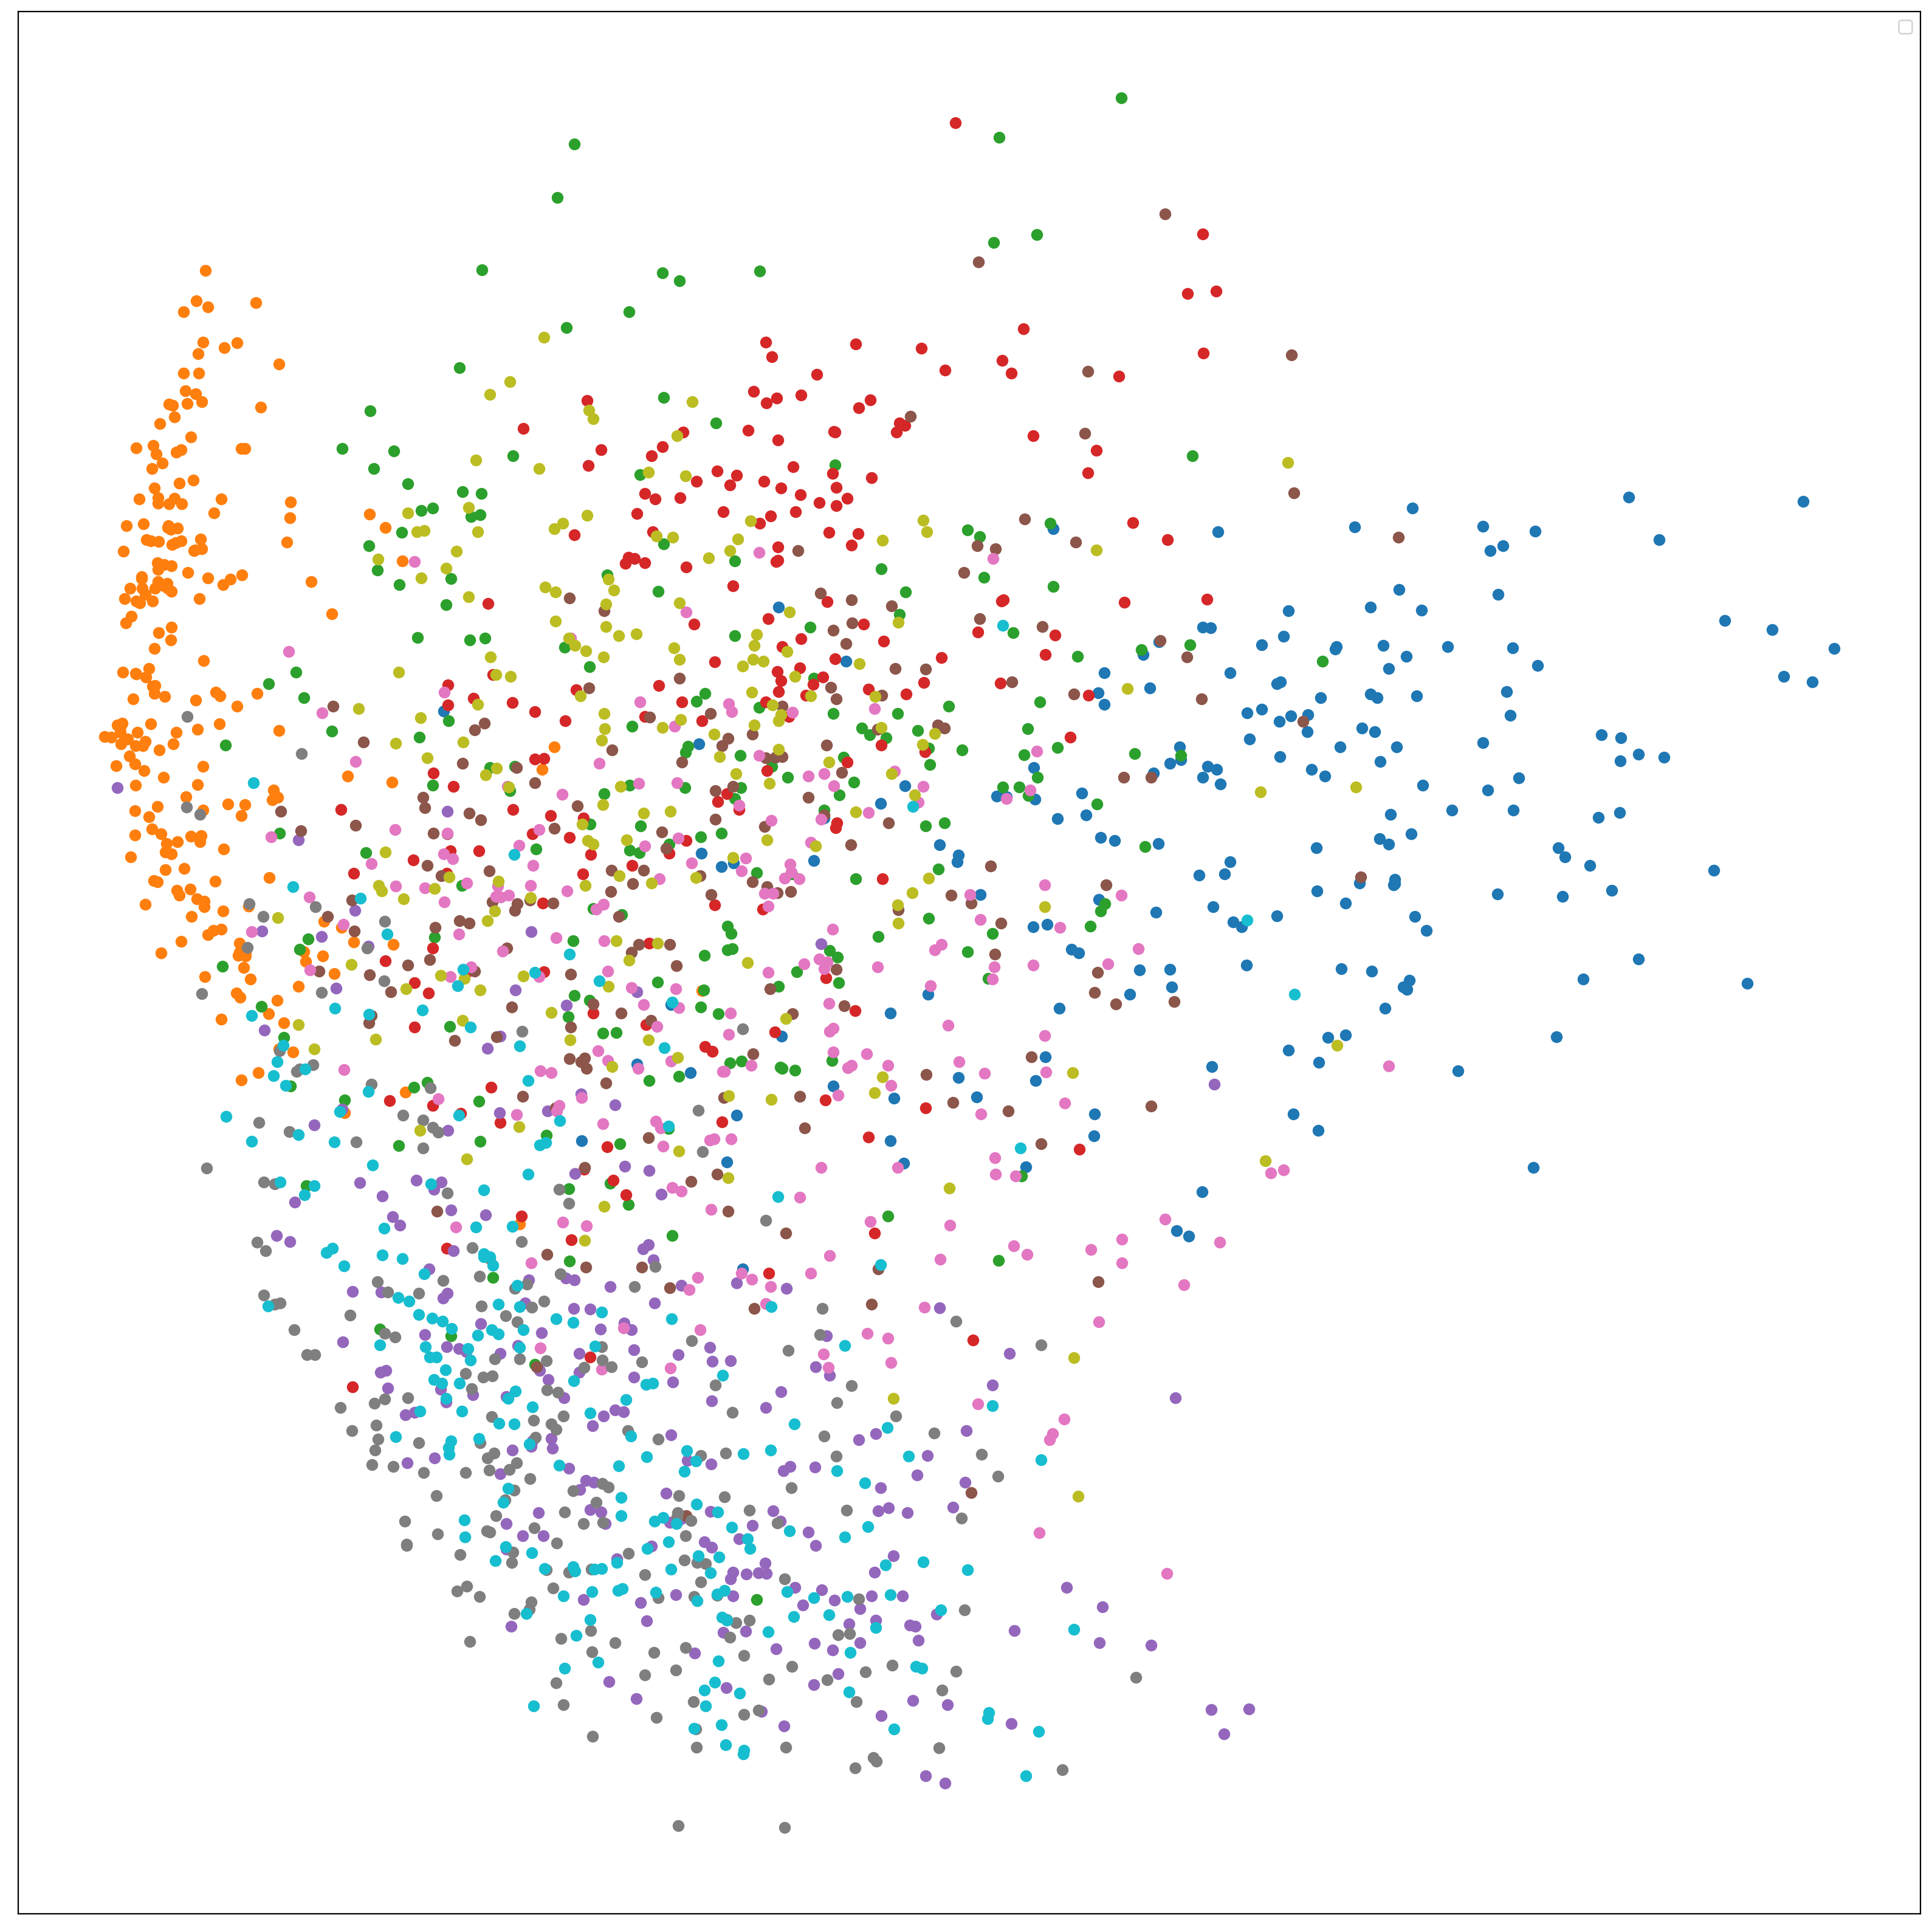

In [11]:
plot_2d_mnist_scatter(X_pca_embedded, y_small)

### T-distributed Stochastic Neighbour Embedding (T-SNE)

Make sure to have a look on this increadible [article on T-SNE](https://distill.pub/2016/misread-tsne/).

Use `T-SNE` function to embed `X_small` in two dimensions. Store the result in `X_tsne_embedded`. <BR>
Use:
 * `n_iter=500` argument to limit the number of T-SNE iterations, 
 * `verbose=2` argument to see a verbose output during embedding.

In [12]:
from sklearn.manifold import TSNE

tsne = TSNE(n_components=2, n_iter=500, verbose=2)
X_tsne_embedded = tsne.fit_transform(X_small)

[t-SNE] Computing 91 nearest neighbors...
[t-SNE] Indexed 2000 samples in 0.001s...
[t-SNE] Computed neighbors for 2000 samples in 1.221s...
[t-SNE] Computed conditional probabilities for sample 1000 / 2000
[t-SNE] Computed conditional probabilities for sample 2000 / 2000
[t-SNE] Mean sigma: 2.528207
[t-SNE] Computed conditional probabilities in 0.258s
[t-SNE] Iteration 50: error = 77.8388367, gradient norm = 0.0137023 (50 iterations in 4.791s)
[t-SNE] Iteration 100: error = 75.6759109, gradient norm = 0.0004194 (50 iterations in 3.200s)
[t-SNE] Iteration 150: error = 75.6410217, gradient norm = 0.0007201 (50 iterations in 7.503s)
[t-SNE] Iteration 200: error = 75.5782776, gradient norm = 0.0006917 (50 iterations in 9.003s)
[t-SNE] Iteration 250: error = 75.5438690, gradient norm = 0.0002524 (50 iterations in 9.999s)
[t-SNE] KL divergence after 250 iterations with early exaggeration: 75.543869
[t-SNE] Iteration 300: error = 1.7901143, gradient norm = 0.0210764 (50 iterations in 7.694s)

In [13]:
X_tsne_embedded.shape

(2000, 2)

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


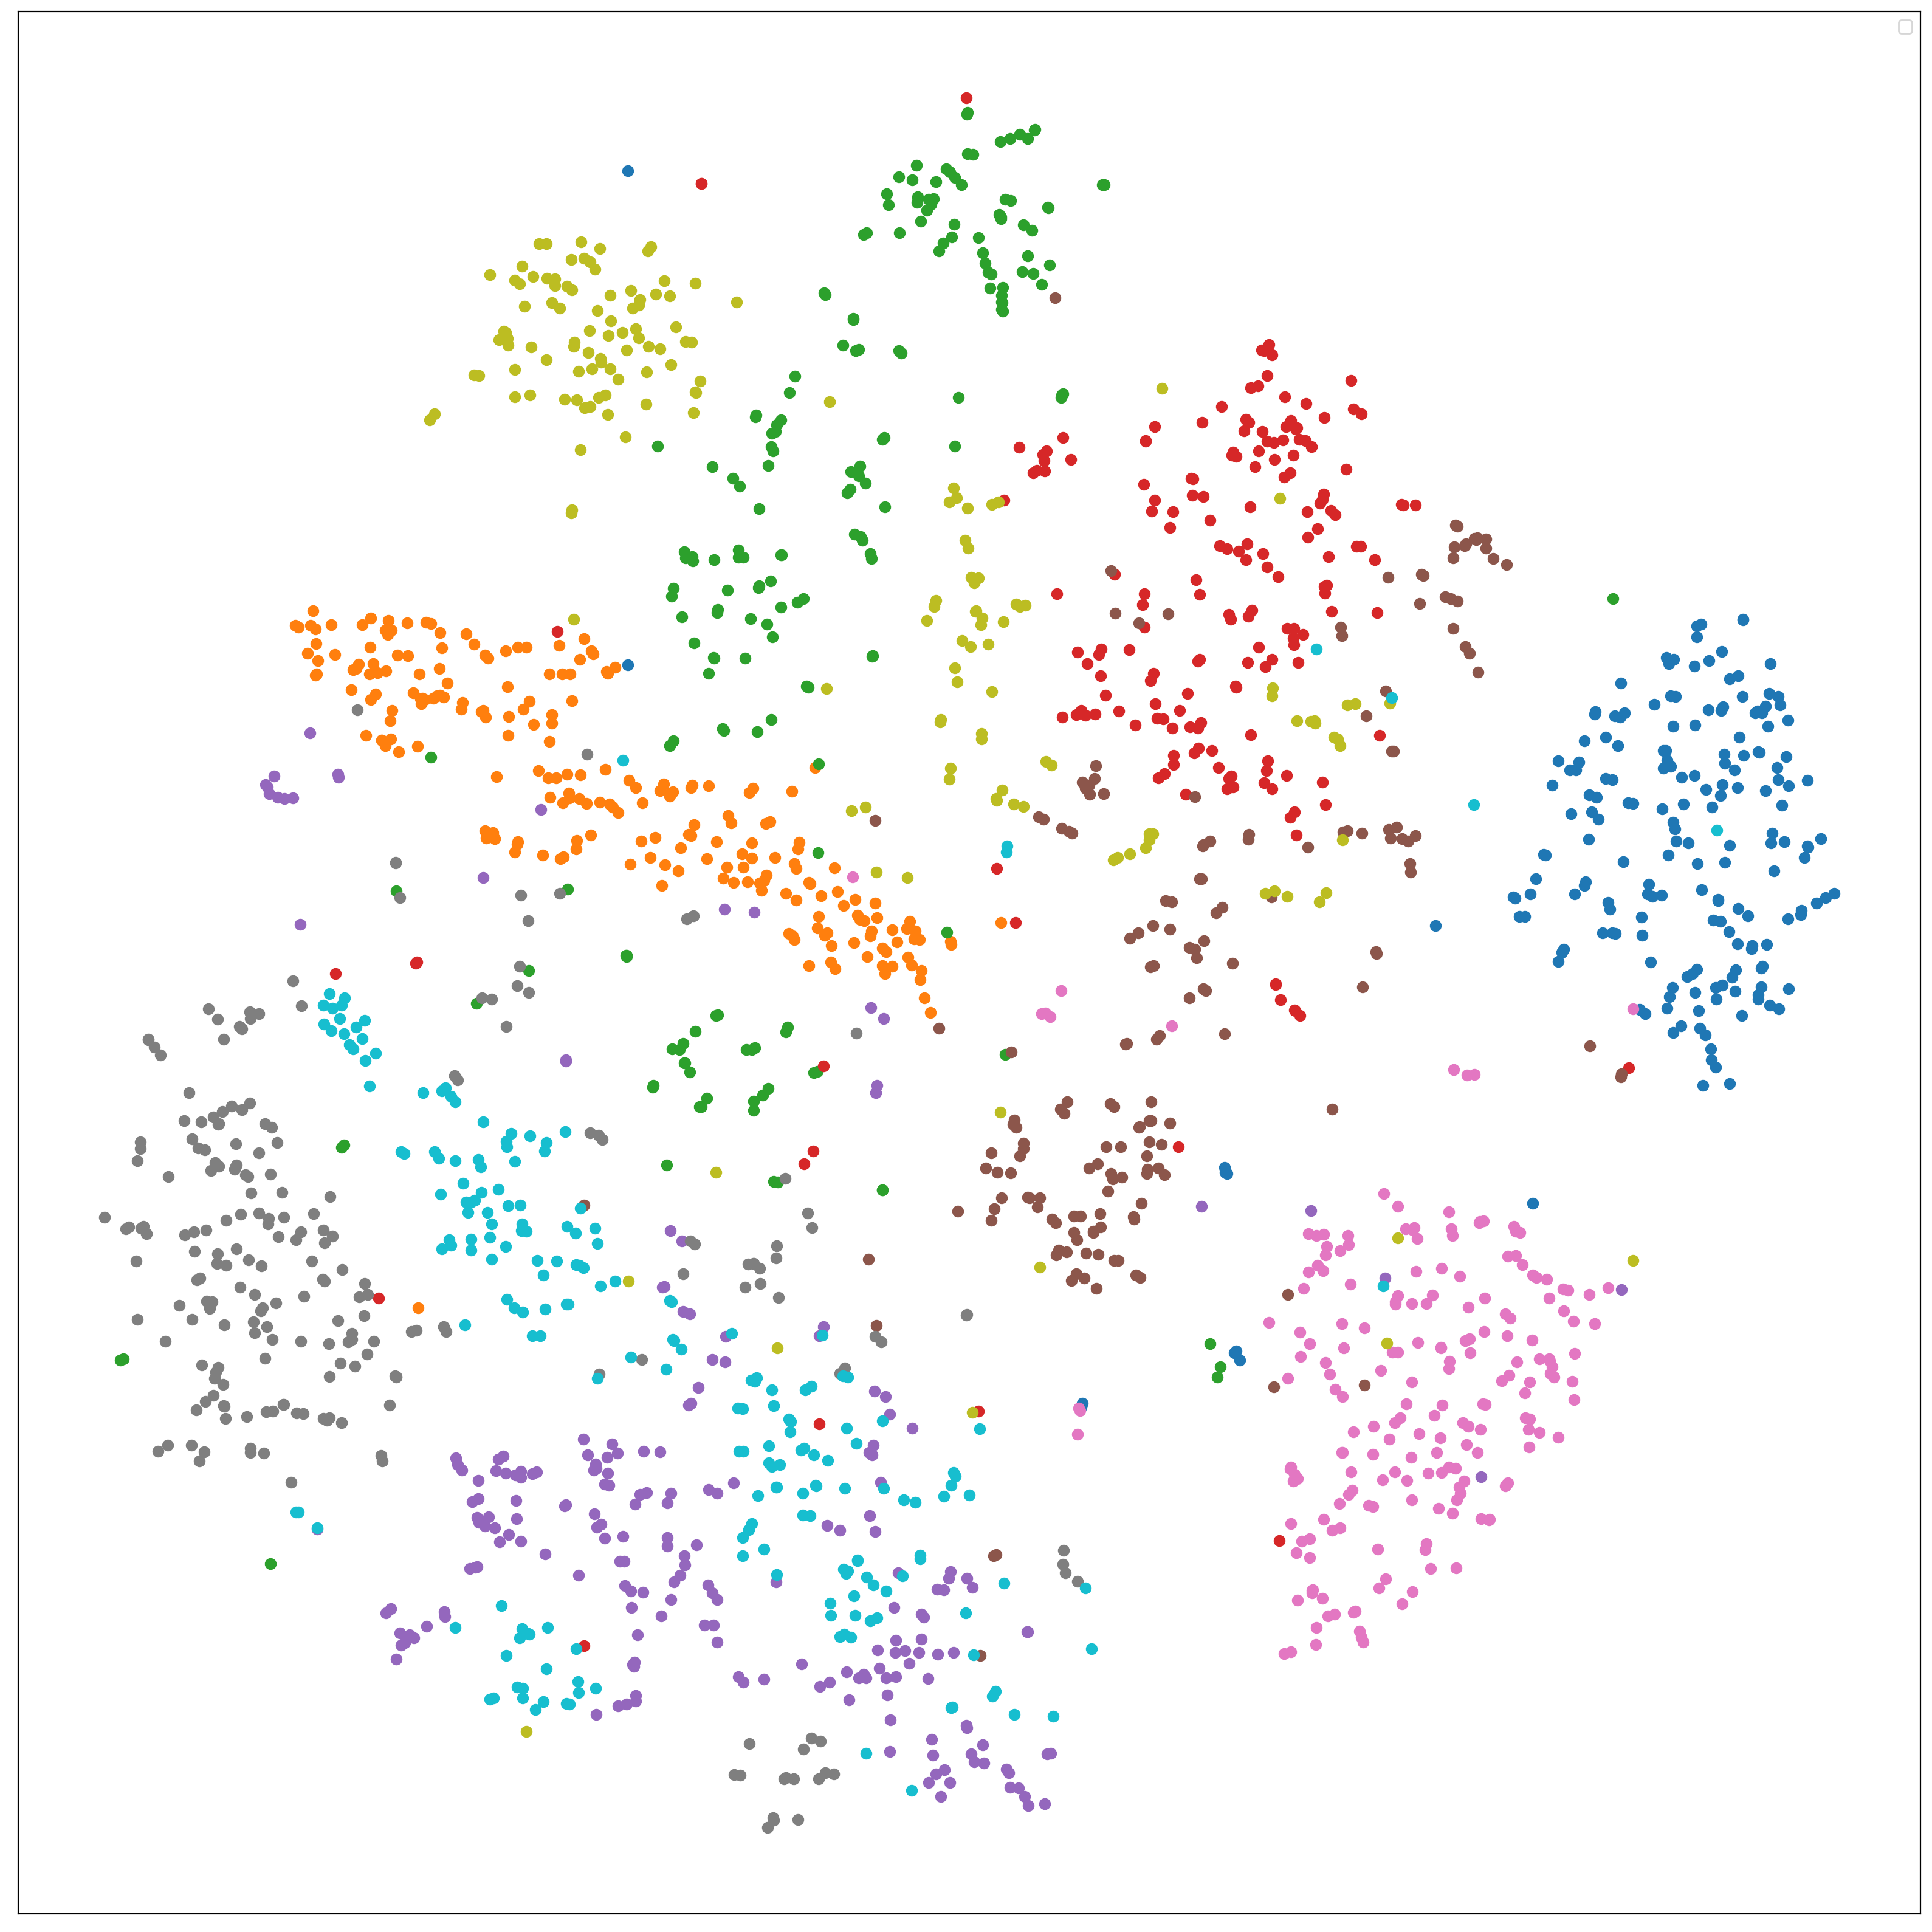

In [14]:
plot_2d_mnist_scatter(X_tsne_embedded, y_small)

### 3D interactive plots with plotly

In [15]:
import plotly.plotly as py
import plotly.graph_objs as go
from plotly.offline import init_notebook_mode, iplot

init_notebook_mode(connected=True)

def plot_3d_mnist_plotly_scatter(X, y):
    def make_trace(i):
        digit_indeces = y == i
        return go.Scatter3d(
            x=X[digit_indeces, 0],
            y=X[digit_indeces, 1],
            z=X[digit_indeces, 2],
            mode='markers',
            name=str(i),
            marker=dict(
                color=i,
                colorscale='Jet',
                size=4,
                symbol='circle',
                line=dict(
                    color='rgb(204, 204, 204)',
                    width=1
                )
            )
        )
        
    traces = [make_trace(i) for i in range(10)]
    
    layout = go.Layout(margin=dict(l=0, r=0, b=0, t=0))
    fig = go.Figure(data=traces, layout=layout)
    iplot(fig)

Use PCA function to embed `X_small` in **three** dimensions. Store the result in `X_3d_pca_embedded`.

In [16]:
pca_3d = PCA(n_components=3)
pca_3d.fit(X_small)
X_3d_pca_embedded = pca_3d.transform(X_small)

In [17]:
X_3d_pca_embedded.shape

(2000, 3)

In [18]:
plot_3d_mnist_plotly_scatter(X_3d_pca_embedded, y_small)

## Classification task

In [19]:
from sklearn.model_selection import train_test_split
SAMPLES_LIMIT=10000
X_train, X_test, y_train, y_test = train_test_split(X[:SAMPLES_LIMIT], y[:SAMPLES_LIMIT], test_size=0.2)

In [20]:
from sklearn import svm
classifier = svm.SVC(C=1, gamma=0.001)
classifier.fit(X_train, y_train)

SVC(C=1, gamma=0.001)

In [21]:
from sklearn import metrics

predicted = classifier.predict(X_test)

print("Classification report for classifier {}:\n{}\n".format(
    classifier, metrics.classification_report(y_test, predicted)))

Classification report for classifier SVC(C=1, gamma=0.001):
              precision    recall  f1-score   support

           0       0.95      0.97      0.96       202
           1       0.92      0.98      0.95       215
           2       0.94      0.91      0.92       211
           3       0.92      0.85      0.88       216
           4       0.91      0.93      0.92       202
           5       0.84      0.86      0.85       185
           6       0.91      0.98      0.94       191
           7       0.92      0.91      0.91       206
           8       0.90      0.82      0.86       186
           9       0.88      0.89      0.88       186

    accuracy                           0.91      2000
   macro avg       0.91      0.91      0.91      2000
weighted avg       0.91      0.91      0.91      2000




Calculate and display the confision matrix for `predicted` and `y_test` (use metrics package).

In [22]:
confusion_matrix = metrics.confusion_matrix(y_true=y_test, y_pred=predicted)

print("Confusion matrix:\n{}".format(confusion_matrix))

Confusion matrix:
[[195   0   1   1   1   0   1   1   2   0]
 [  0 210   1   0   0   3   0   0   1   0]
 [  2   4 191   0   4   1   5   1   3   0]
 [  0   2   4 184   0  17   1   3   4   1]
 [  0   1   2   0 188   0   1   1   1   8]
 [  2   1   1  10   2 159   5   0   4   1]
 [  1   1   0   0   2   0 187   0   0   0]
 [  0   3   2   0   3   0   1 188   0   9]
 [  2   7   1   4   4   8   4   1 152   3]
 [  3   0   1   2   2   2   0  10   1 165]]
